In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utils as ut

In [2]:
# this string must be passed during the execution of gillespie_test.exe
data_dir = '../data/chem_evol_e/'

In [14]:
params = dict()

# LV parameters
params['process_type'] = 'chem_evole'
#params['delta0'] = 1
params['eta0'] = 1
params['alpha0'] = 0.01
params['M'] = 200
params['mut_rate'] = 0.001
params['delta_alpha'] = 0.1
params['alpha_max'] = params['alpha0']*params['M']*2


# Gillespie parameters
params['end_cond'] = 'time'
params['max_steps'] = 20000000
params['traj_step'] = 1000
n_states = int(params['alpha_max']/params['delta_alpha'])
params['init_state'] = np.zeros(n_states) # Initial condition
params['init_state'][0] = params['M']
params['N_realizations'] = 50

In [15]:
ut.write_params(params, data_dir, 'param.txt')

### Import

In [16]:
data_dir = '../data/chem_evol_e/'
params = ut.read_params(data_dir+'param.txt')
n_states = int(params['alpha_max']/params['delta_alpha'])

In [17]:
traj, labels = ut.read_traj(data_dir+'traj11.txt')

In [18]:
N_traj = traj[:,1:].sum(axis=1)
alphas = np.linspace(params['delta_alpha'], params['alpha_max'], n_states)
av_alpha_traj = np.sum(traj[:,1:]*alphas, axis=1) / N_traj
std_alpha_traj = np.sqrt(np.sum(traj[:,1:]*alphas**2, axis=1) / N_traj - av_alpha_traj**2)

<ipython-input-18-91b438e50e4c>:4: RuntimeWarning: invalid value encountered in sqrt
  std_alpha_traj = np.sqrt(np.sum(traj[:,1:]*alphas**2, axis=1) / N_traj - av_alpha_traj**2)


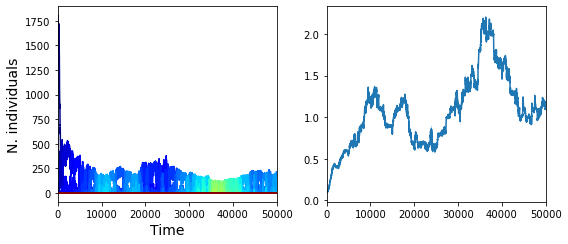

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,3.5))
colors = plt.cm.jet(np.linspace(0,1,n_states))
xlim = [0,traj[:,0][-1]]
#plt.ylim([0,2200])
ax1.set_xlabel('Time',fontsize=14)
ax1.set_ylabel('N. individuals',fontsize=14)
ax1.set_xlim(xlim)
for i in range(len(labels)-1):
    ax1.plot(traj[:,0], traj[:,1:][:,i], c=colors[i], label=r'$\alpha=%3.2f$'%((i+1)*params['delta_alpha']))
#ax1.legend(fontsize=10)

ax2.set_xlim(xlim)
ax2.plot(traj[:,0], av_alpha_traj)
ax2.fill_between(traj[:,0], av_alpha_traj-std_alpha_traj/2, av_alpha_traj+std_alpha_traj/2)
plt.tight_layout()
#plt.savefig('../plots/LV/traj.png', dpi=200, transparent=True)

In [20]:
cumul_av_alpha = np.zeros(len(av_alpha_traj))
for i in range(len(labels)-1):
    cumul_av_alpha = np.row_stack((cumul_av_alpha, cumul_av_alpha[-1] + traj[:,1:][:,i]))

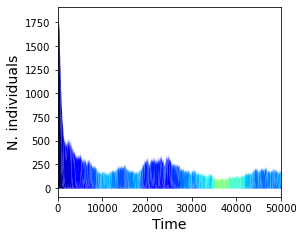

In [21]:
fig, (ax1) = plt.subplots(1,1,figsize=(4,3.5))
colors = plt.cm.jet(np.linspace(0,1,n_states))
xlim = [0,traj[:,0][-1]]
#plt.ylim([0,2200])
ax1.set_xlabel('Time',fontsize=14)
ax1.set_ylabel('N. individuals',fontsize=14)
ax1.set_xlim(xlim)
for i in range(len(labels)-1):
    ax1.fill_between(traj[:,0], cumul_av_alpha[i], cumul_av_alpha[i+1], color=colors[i],lw=0)
#ax1.legend(fontsize=10)

In [22]:
alphas = np.linspace(params['delta_alpha'], params['alpha_max'], n_states)
av_av_alpha = np.zeros(len(av_alpha_traj))
params['N_realizations'] = 50
for i in range(int(params['N_realizations'])):
    traj, labels = ut.read_traj(data_dir+'traj'+str(i)+'.txt')
    N_traj = traj[:,1:].sum(axis=1)
    av_alpha_traj = np.sum(traj[:,1:]*alphas, axis=1) / N_traj
    #plt.plot(av_alpha_traj)
    av_av_alpha += av_alpha_traj/params['N_realizations']

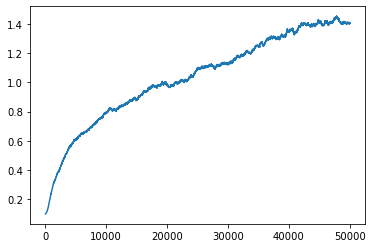

In [23]:
plt.plot(traj[:,0], av_av_alpha)